In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datasets import load_dataset
from PIL import Image
import io
import os
import flask
from flask import Flask, request, jsonify

In [ ]:
dataset = load_dataset("PedroSampaio/fruits-360")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

(…)-00000-of-00001-086dc013443c484c.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

(…)-00000-of-00001-0d294abe3826b2e6.parquet:   0%|          | 0.00/98.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67690 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22688 [00:00<?, ? examples/s]

In [ ]:
print(len(dataset["train"]))

67690


In [ ]:
classes = dataset["train"].features["label"].names
num_classes = len(classes)

In [ ]:
# stocker les images
import tempfile
import shutil
import os

#
def create_image_folders(dataset_split, base_dir):
    os.makedirs(base_dir, exist_ok=True)


    for class_name in classes:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)


    for i, example in enumerate(dataset_split):
        img = example["image"]
        label_id = example["label"]
        class_name = classes[label_id]

        # Sauve
        img_path = os.path.join(base_dir, class_name, f"img_{i}.jpg")
        img.save(img_path)

    return base_dir

In [ ]:
#  les dossiers temporaires
train_dir = tempfile.mkdtemp(prefix="train_")
test_dir = tempfile.mkdtemp(prefix="test_")

In [33]:
print("entraînement")
create_image_folders(dataset["train"], train_dir)
print("test")
create_image_folders(dataset["test"], test_dir)

entraînement
test


'/tmp/test_l0k6ka47'

In [ ]:
# Configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# générateurs de données
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 22688 images belonging to 113 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers:
    if "block_13" in layer.name or "block_14" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False


In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      32,113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 113)                 │          57,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,429,105 (131.34 MB)

 Trainable params: 32,646,385 (124.54 MB)

 Non-trainable params: 1,782,720 (6.80 MB)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_save_path = '/content/drive/MyDrive/computer_vusion/projet/best_model.h5'

In [ ]:
# Définir des callbacks
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Calculer  époque
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

# Entraîner
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=8,
    validation_data=test_generator,
    validation_steps=50,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1115 - loss: 5.2135
Epoch 1: val_accuracy improved from -inf to 0.04375, saving model to /content/drive/MyDrive/computer_vusion/projet/best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 213ms/step - accuracy: 0.1134 - loss: 5.1913 - val_accuracy: 0.0437 - val_loss: 3.9603
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4707 - loss: 2.1986
Epoch 2: val_accuracy improved from 0.04375 to 0.25625, saving model to /content/drive/MyDrive/computer_vusion/projet/best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.4720 - loss: 2.1933 - val_accuracy: 0.2562 - val_loss: 2.9829
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6704 - loss: 1.2448
Epoch 3: val_accuracy improved from 0.25625 to 0.34938, saving model to /content/drive/MyDrive/computer_vusion/projet/best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.6715 - loss: 1.2415 - val_accuracy: 0.3494 - val_loss: 2.5644
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8419 - loss: 0.6708
Epoch 4: val_accuracy improved from 0.34938 to 0.39812, saving model to /content/drive/MyDrive/computer_vusion/projet/best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.8416 - loss: 0.6715 - val_accuracy: 0.3981 - val_loss: 2.2719
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8910 - loss: 0.4317
Epoch 5: val_accuracy improved from 0.39812 to 0.42437, saving model to /content/drive/MyDrive/computer_vusion/projet/best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.8910 - loss: 0.4317 - val_accuracy: 0.4244 - val_loss: 2.1706
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9145 - loss: 0.3488
Epoch 6: val_accuracy improved from 0.42437 to 0.47688, saving model to /content/drive/MyDrive/computer_vusion/projet/best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 411ms/step - accuracy: 0.9146 - loss: 0.3482 - val_accuracy: 0.4769 - val_loss: 1.7939
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9273 - loss: 0.2720
Epoch 7: val_accuracy improved from 0.47688 to 0.59688, saving model to /content/drive/MyDrive/computer_vusion/projet/best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.9274 - loss: 0.2715 - val_accuracy: 0.5969 - val_loss: 1.4815
Epoch 8/8
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9394 - loss: 0.2082
Epoch 8: val_accuracy did not improve from 0.59688
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.9394 - loss: 0.2082 - val_accuracy: 0.5250 - val_loss: 1.5072
Restoring model weights from the end of the best epoch: 7.


In [ ]:
# Charger les poids du modèle
model.load_weights('/content/drive/MyDrive/computer_vusion/projet/best_model.h5')
y_pred = model.predict(test_generator, steps=validation_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

709/709 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step


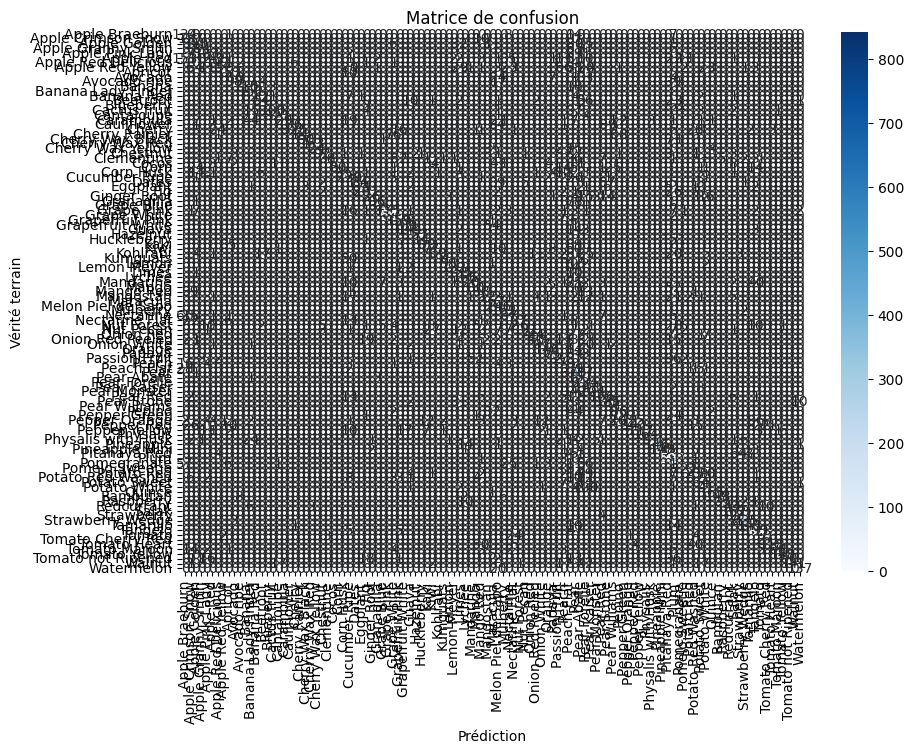

In [ ]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()


In [ ]:
# Rapport de classification
report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)


                     precision    recall  f1-score   support

     Apple Braeburn       0.29      0.82      0.43       164
 Apple Crimson Snow       0.45      0.93      0.61       148
       Apple Golden       0.69      0.70      0.69       485
 Apple Granny Smith       0.89      0.51      0.65       164
    Apple Pink Lady       0.58      0.68      0.62       152
          Apple Red       0.90      0.30      0.45       472
Apple Red Delicious       0.79      0.86      0.82       166
   Apple Red Yellow       0.95      0.15      0.26       383
            Apricot       0.67      0.93      0.78       164
            Avocado       0.38      0.46      0.42       143
       Avocado ripe       0.41      0.04      0.08       166
             Banana       1.00      0.69      0.82       166
 Banana Lady Finger       0.49      1.00      0.66       152
         Banana Red       1.00      0.67      0.81       166
           Beetroot       0.65      0.36      0.46       150
          Blueberry    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd

cm_df = pd.DataFrame(cm, index=classes, columns=classes)

print(cm_df.head(20))



                     Apple Braeburn  Apple Crimson Snow  Apple Golden  \
Apple Braeburn                  134                   0             0   
Apple Crimson Snow                0                 137             0   
Apple Golden                      0                   0           340   
Apple Granny Smith                0                   0             8   
Apple Pink Lady                   0                   7             0   
Apple Red                       153                   3            11   
Apple Red Delicious               0                   0             0   
Apple Red Yellow                  0                   6            34   
Apricot                           0                   0             0   
Avocado                           0                   0             0   
Avocado ripe                      0                   0             0   
Banana                            0                   0             0   
Banana Lady Finger                0                

In [ ]:
#model.save('/content/drive/MyDrive/computer_vusion/best_modele.h5')
model.save('/content/drive/MyDrive/computer_vusion/projet/my_model_fruit360.keras')